<a href="https://colab.research.google.com/github/fabiotorrib/riscv_tp/blob/main/TP2_OC1_2025_1_Caminho_de_Dados_em_Verilog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático 2 - Caminho de Dados em Verilog

O objetivo desse trabalho é se familiarizar com a Linguagem de Descrição de Hardware Verilog. Essa é uma implementação do RISC-V 5 estágios em Verilog. Sua tarefa neste trabalho será alterar o caminho de dados fornecido a fim de incluir mais operações e módulos descritos na especificação do trabalho.

**Aluno(s):**

In [8]:
#@title Instalação do Verilog
#@markdown Não é necessário alterar nada nesse bloco de código.

!pip install git+https://github.com/lesc-ufv/cad4u.git &> /dev/null
!git clone https://github.com/lesc-ufv/cad4u &> /dev/null
%load_ext plugin
!pip install gradio  &> /dev/null
print("OK!")
import os, subprocess, tempfile, uuid, sys

from IPython.core.magic import Magics, cell_magic, magics_class
from IPython.core.magic_arguments import argument, magic_arguments, parse_argstring
from IPython.display import display, Image, SVG #, PNG


def print_out(args):
  try:
    output = subprocess.check_output(args, stderr=subprocess.STDOUT)
    output = output.decode('utf8')
    return output
  except Exception as e:
    print(e)
    return e

def compile(file_path):
  args = ['iverilog', file_path + '.v', "-o", file_path + ".out"]
  print_out(args)

def run2str(file_path):
  file_path = file_path + ".out"
  return print_out(file_path)

def waveform(filename, sign_list, time_begin, time_end, base):
  sys.path.insert(0,'.')
  from cad4u.verilog.vcd_parser.vcd_plotter import VcdPlotter
  op_dict = [[{}]]
  vcd_plt = VcdPlotter('/content/%s'%filename)
  return vcd_plt.return_show(op_dict, sign_list, time_begin, time_end, base)

OK!


Installing. Please wait... done!


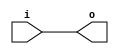

In [9]:
#@title Verificando a instalação do Verilog
#@markdown Não é necessário alterar nada nesse bloco de código.

%%print_verilog
module foo(input i, output o);
assign o = i;
endmodule

# Implementação do RISC-V

Nessa seção implementaremos cada uma das unidades necessárias para que simulemos o processador. O trabalho de vocês é identificar onde e como precisamos alterar essas unidades para que as novas instruções funcionem como esperado.

## Instruções implementadas

- R-type: `SUB`, `MUL`, `SLL`, `SLT`, `SLTU`, `XOR`, `SRA`, `OR`, `AND` e `SRL`
- I-type: `ADDI`, `SLLI`, `SLTI`, `SLTUI`, `XORI`, `SRAI`, `SRLI`, `ANDI` e `LW`
- `SW`
- Branches: `BNE`, `BLT`, `BGE`, `BLTU` e `BGEU`

## Fetch Unit

A Fetch Unit é responsável por buscar as instruções a serem executadas da memória de instruções, utilizando o contador de programa (PC) para determinar o endereço da próxima instrução. Essa unidade calcula o próximo valor do PC, considerando o fluxo sequencial (PC + 4) ou desvios condicionais, dependendo dos sinais de controle (`branch` e `zero`). A instrução correspondente ao endereço calculado é então enviada como saída para as próximas etapas do pipeline.

Um esquemático de como essa unidade está implementada está diponível nesse [sketch](https://excalidraw.com/#json=_tYS0LobrxLeEAWK2kp8I,G5Sa4eKxcnwZa9Kxzd0Ftw).

In [10]:
%%writefile fetch.v

module fetch (input zero, rst, clk, branch, input [31:0] sigext, output [31:0] inst);

  wire [31:0] pc, pc_4, new_pc;

  assign pc_4 = 4 + pc; // pc+4  Adder
  assign new_pc = (branch & zero) ? pc + sigext : pc_4; // new PC Mux

  PC program_counter(new_pc, clk, rst, pc);

  reg [31:0] inst_mem [0:31];

  assign inst = inst_mem[pc[31:2]];

  initial begin
    // Exemplos

`include "mycode.v"
  end

endmodule

module PC (input [31:0] pc_in, input clk, rst, output reg [31:0] pc_out);

  always @(posedge clk) begin
    pc_out <= pc_in;
    if (~rst)
      pc_out <= 0;
  end

endmodule

Writing fetch.v


## Decode Unit

A Decode Unit é responsável por interpretar a instrução buscada na memória e extrair seus campos relevantes, como registradores, funções e operandos imediatos. Essa unidade inclui o banco de registradores, onde os valores dos registradores são lidos ou escritos, e a unidade de controle, que decodifica o opcode da instrução para gerar sinais de controle necessários para a execução. Além disso, a Decode Unit gera sinais como `alusrc`, `memread`, `branch`, e `aluop`, e calcula valores imediatos (`ImmGen`) para instruções que os utilizam. Isso permite preparar os dados e controles necessários para as próximas etapas no pipeline.


Dois sketchs podem ajudá-los a entender melhor como essa unidade está implementada:
1. [Estrutura geral](https://excalidraw.com/#json=CipxEL8AMakITSPZ7EtdJ,JlsAp9wW9NsyiZKEXiMKVA)
2. [Unidade de Controle com exemplo do ADD e banco de registradores](https://excalidraw.com/#json=DCwa5ZX-BiiVuZzGHAlst,KFzrvWQ8PgjCEyq3HI1uHg)


In [114]:
%%writefile decode.v
module decode (input [31:0] inst, writedata, input clk, output [31:0] data1, data2, ImmGen, output alusrc, memread, memwrite, memtoreg, branch,
               output [1:0] aluop, output [9:0] funct);

  wire branch, memread, memtoreg, MemWrite, alusrc, regwrite;
  wire [1:0] aluop;
  wire [4:0] writereg, rs1, rs2, rd;
  wire [6:0] opcode;
  wire [9:0] funct;
  wire [6:0] funct7;
  wire [2:0] funct3;
  wire [31:0] ImmGen;


  assign opcode = inst[6:0];
  assign rs1    = inst[19:15];
  assign rs2    = inst[24:20];
  assign rd     = inst[11:7];
  assign funct7 = inst[31:25];
  assign funct3 = inst[14:12];
  assign funct = {funct7,funct3};

  ControlUnit control (opcode, inst, alusrc, memtoreg, regwrite, memread, memwrite, branch, aluop, ImmGen);

  Register_Bank Registers (clk, regwrite, rs1, rs2, rd, writedata, data1, data2);

endmodule

module ControlUnit (input [6:0] opcode, input [31:0] inst, output reg alusrc, memtoreg, regwrite, memread, memwrite, branch, output reg [1:0] aluop, output reg [31:0] ImmGen);

  always @(*) begin
    alusrc   <= 0;
    memtoreg <= 0;
    regwrite <= 0;
    memread  <= 0;
    memwrite <= 0;
    branch   <= 0;
    aluop    <= 0;
    ImmGen   <= 0;
    case(opcode)
    	7'b0110011: begin // R type == 51 = 0x33
    	    regwrite <= 1;
    	    aluop    <= 2;
		end
		7'b0010011: begin // addi == 19 ou 0x13, slti, xori, .....
	        alusrc   <= 1;
	        regwrite <= 1;
          aluop    <= 3;
	        ImmGen   <= {{20{inst[31]}},inst[31:20]};
		end
		7'b0000011: begin // lw == 3
        	alusrc   <= 1;
        	memtoreg <= 1;
        	regwrite <= 1;
        	memread  <= 1;
        	ImmGen   <= {{20{inst[31]}},inst[31:20]};
      	end
		7'b0100011: begin // sw == 35
        	alusrc   <= 1;
        	memwrite <= 1;
        	ImmGen   <= {{20{inst[31]}},inst[31:25],inst[11:7]};
      	end
    7'b1100011: begin // BRANCH
          branch <= 1;
          aluop  <= 1;
        end
    7'b0010111: begin // TIPO U
          ImmGen <= {inst[31:12], 12'b0};
    endcase
  end

endmodule

module Register_Bank (input clk, regwrite, input [4:0] read_reg1, read_reg2, writereg, input [31:0] writedata, output [31:0] read_data1, read_data2);

  integer i;
  reg [31:0] reg_bank [0:31]; // 32 registers de 32 bits cada

  // fill the memory
  initial begin
    for (i = 0; i <= 31; i++)
      reg_bank[i] <= i;
  end

  assign read_data1 = reg_bank[read_reg1];
  assign read_data2 = reg_bank[read_reg2];

  always @(posedge clk) begin
    if (regwrite)
      reg_bank[writereg] <= writedata;
  end

endmodule

Overwriting decode.v


## Execution Unit

A Execution Unit é responsável por realizar operações aritméticas, lógicas e de controle de fluxo, utilizando os operandos e sinais de controle gerados pelas etapas anteriores. Essa unidade contém a ALU (Arithmetic Logic Unit), que executa as instruções definidas pela lógica do `alucontrol`, e opera com dois operandos, podendo usar valores imediatos quando o sinal `alusrc` está ativado. Além disso, a unidade gera o resultado da operação (`aluout`) e um sinal lógico (`zero`), usado para verificar condições de desvio. A lógica de controle da ALU é configurada com base no tipo de instrução e nos campos de função (`funct`), permitindo a execução de uma variedade de operações, como somas, deslocamentos e comparações.

Esse [sketch](https://excalidraw.com/#json=_bkljhRxzuhoEKebcmdU1,RJRx8Xe9Drf8F3J7RCVUow) mostra o **desenho do controle da ALU** que está implementado no código abaixo.

In [116]:
%%writefile execute.v
module execute (input [31:0] in1, in2, ImmGen, input alusrc, input [1:0] aluop, input [9:0] funct, output zero, output [31:0] aluout);

  wire [31:0] alu_B;
  wire [3:0] aluctrl;

  assign alu_B = (alusrc) ? ImmGen : in2 ;
  wire zero1;
  wire [2:0] f3;
  assign f3 = funct[2:0];
  assign zero = (f3 == 3'b000) ? zero1 :
                (f3 == 3'b001) ? ~zero1 :
                (f3 == 3'b100) ? aluout[31]:
                (f3 == 3'b101) ? ~aluout[31] :
                (f3 == 3'b110) ? in1[31:0] < alu_B[31:0] :
                (f3 == 3'b111) ? ~(in1[31:0] < alu_B[31:0]) : 0;


  //Unidade Lógico Aritimética
  ALU alu (aluctrl, in1, alu_B, aluout, zero1);

  alucontrol alucontrol (aluop, funct, aluctrl);

endmodule

module alucontrol (input [1:0] aluop, input [9:0] funct, output reg [3:0] alucontrol);

  wire [7:0] funct7;
  wire [2:0] funct3;
  wire [3:0] ALUopcode;

  assign funct3 = funct[2:0];
  assign funct7 = funct[9:3];
  assign ALUopcode = {funct7[5],funct3};

  always @(*)
  begin
    case (aluop)
      0: alucontrol <= 4'd2; // ADD to SW and LW
      1: alucontrol <= 4'd6; // SUB to branch
      2: case (funct3)
           0: alucontrol <= (funct7 == 1) ? /*MUL*/ 4'd10 : /*SUB*/ 4'd6;
           1: alucontrol <= 4'd3; // SLL
           2: alucontrol <= 4'd7; // SLT
           3: alucontrol <= 4'd9; //SLTU
           4: alucontrol <= 4'd4; // XOR
           5: alucontrol <= (funct7[5])? 4'd5:4'd8; // SRA ou SRL
           6: alucontrol <=  4'd1; // OR
           7: alucontrol <= 4'd0; // AND
           default: alucontrol <= 4'd15; // Nop
         endcase
      3: case (funct3) // immediate
           0: alucontrol <= 4'd2; //ADDI
           1: alucontrol <= 4'd3; // SLLI
           2: alucontrol <= 4'd7; // SLTI
           3: alucontrol <= 4'd9; //SLTUI
           4: alucontrol <= 4'd15; // NOP
           5: alucontrol <= (funct7[5])? 4'd5:4'd8; // SRAI or SRLI
           7: alucontrol <= 4'd0; // ANDI
           default: alucontrol <= 4'd15; // Nop
         endcase
    endcase
  end
endmodule

module ALU (input [3:0] alucontrol, input [31:0] A, B, output reg [31:0] aluout, output zero);

  assign zero = (aluout == 0); // Zero recebe um valor lógico caso aluout seja igual a zero.

  wire [31:0] t,sh,p;
  slt subt(A,B,t);
  shiftRA shift(A,B[4:0],sh);


  always @(*) begin
      case (alucontrol)
        0: aluout <= A & B; // AND
        1: aluout <= A | B; // OR
        2: aluout <= A + B; // ADD
        3: aluout <= A << B[4:0]; // SSL A << B Shift left logico
        4: aluout <= A ^ B; // XOR
        5: aluout <= sh;
        6: aluout <= A - B; // SUB
        7: aluout <= t; //A < B ? 32'd1:32'd0; //SLT
        8: aluout <= A >> B[4:0];
        9: aluout <= A < B ? 32'd1:32'd0; //SLTU
       10: aluout <= A * B; // MUL
      default: aluout <= 0; //default 0, Nada acontece;
    endcase
  end
endmodule

module slt(input [31:0]a,b, output [31:0] s );
wire [31:0] sub;
assign sub = a - b;
assign s = (sub[31])?1:0;
endmodule


module shiftRA (input [31:0]a,input [4:0]b, output [31:0] o );
wire [31:0] s;
wire [31:0] t;
wire [31:0] m;

assign m = {32{1'b1}};
assign s = m >> b;
assign t = a >> b;
assign o = (a[31])?(~s|t):t;
endmodule

Overwriting execute.v


## Memory Unit

A Memory Unit é responsável por realizar operações de leitura e escrita na memória de dados. Quando o sinal `memread` está ativado, o valor armazenado no endereço fornecido é lido e enviado para a saída `readdata`. Quando `memwrite` está ativo, o dado em `writedata` é escrito no endereço especificado. Todas as operações de escrita ocorrem na borda de subida do clock (`clk`).

Esse [sketch](https://excalidraw.com/#json=Fx_T1iJBikBV6xnEsqEw_,iUUe3zbs_TNT-Q1WLYIZWw) tem um desenho quase completo do sistema inteiro.

In [13]:
%%writefile memory.v
module memory (input [31:0] address, writedata, input memread, memwrite, clk, output [31:0] readdata);

  integer i;
  reg [31:0] memory [0:127];

  // fill the memory
  initial begin
    for (i = 0; i <= 127; i++)
      memory[i] <= i;
  end

  assign readdata = (memread) ? memory[address[31:2]] : 0;

  always @(posedge clk) begin
    if (memwrite)
      memory[address[31:2]] <= writedata;
	end
endmodule

Writing memory.v


## Writeback Unit

A Writeback Unit determina o dado que será escrito no banco de registradores. Com base no sinal `memtoreg`, ela seleciona entre o resultado da ALU (`aluout`) ou o dado lido da memória (`readdata`) e envia o valor selecionado para a saída `write_data`.

In [14]:
%%writefile writeback.v

module writeback (input [31:0] aluout, readdata, input memtoreg, output [31:0] write_data);

    assign write_data = (memtoreg) ? readdata : aluout;

endmodule

Writing writeback.v


# Código principal do processador

Abaixo será definido o código que será executado na simulação de RISC-V que construimos nas células anteriores. Siga as instruções disponíveis aqui e na documentação para preencher as informações corretamente.

In [123]:
#@title Cole o hex dump do seu código aqui
#@markdown Coloque aqui o dump do seu código em assembly.
#@markdown Para obter esse código, crie um arquivo no [Venus](https://venus.cs61c.org/) com o código em assembly, vá na aba de simulador e clique em "Dump".
#@markdown
#@markdown ![](https://i.imgur.com/jj5ph5Y.gif)
#@markdown
#@markdown Exemplo:
#@markdown ```
#@markdown addi s0, zero, 2
#@markdown addi s1, zero, 3
#@markdown mul a0, s0, s1
#@markdown ```
#@markdown É transformado no seguinte dump:
#@markdown ```
#@markdown 0x00200413 0x00300493 0x02940533
#@markdown ```

CODE_DUMP = "0x00100313" # @param {type:"string", placeholder:"Cole o hex dump do seu código aqui"}

with open("mycode.v", "w") as mem_code:
    for pos, cmd in enumerate(CODE_DUMP.split(' ')):
        hex = cmd.rstrip("\n")
        line = f"inst_mem[{str(pos)}] <= 32'h{hex};\n"
        mem_code.write(line)

!cat mycode.v

inst_mem[0] <= 32'h0x00100313;


# Execução

A célula abaixo integra todas as unidades do processador (Fetch, Decode, Execute, Memory e Writeback) para simular a execução de instruções em um ciclo de clock. O módulo principal (`riscV`) interliga as etapas do pipeline e realiza o fluxo completo de uma CPU baseada em RISC-V.

**Não é necessário alterar nenhum código nessa seção**


In [124]:
head = """
`include "fetch.v"
`include "decode.v"
`include "execute.v"
`include "memory.v"
`include "writeback.v"

// TOP -------------------------------------------
module riscV (input clk, rst, output [31:0] writedata);

  wire [31:0] inst, sigext, data1, data2, aluout, readdata;
  wire zero, memread, memwrite, memtoreg, branch, alusrc;
  wire [9:0] funct;
  wire [1:0] aluop;

  // FETCH STAGE
  fetch Fetch (zero, rst, clk, branch, sigext, inst);

  // DECODE STAGE
  decode Decode (inst, writedata, clk, data1, data2, sigext, alusrc, memread, memwrite, memtoreg, branch, aluop, funct);

  // EXECUTE STAGE
  execute Execute (data1, data2, sigext, alusrc, aluop, funct, zero, aluout);

  alucontrol Alucontrol (aluop, funct, alucontrol);

  // MEMORY STAGE
  memory Memory (aluout, data2, memread, memwrite, clk, readdata);

  // WRITEBACK STAGE
  writeback Writeback (aluout, readdata, memtoreg, writedata);

  endmodule

module main;
reg clk,res;
wire [31:0] writedata;
reg [5:0] cycle;
wire signed [31:0] Aludebug;
wire signed [31:0] Rs1debug;
wire signed [31:0] Rs2debug;
wire signed [31:0] Imm;
wire f7_5;
wire [6:0] opcode;

riscV CPU (clk, res,  writedata);
assign  f7_5 = CPU.Decode.funct7[5];
assign Aludebug = CPU.Execute.aluout;
assign Rs1debug = CPU.Decode.data1;
assign Rs2debug = CPU.Decode.data2;
assign Imm = CPU.Fetch.sigext;
assign opcode = CPU.inst[6:0];
initial begin
    cycle = 6'b0;
end

always @(posedge clk)
  begin
   if (res) cycle <= cycle+1;
  end


  initial
    begin
      res=0; clk=0;
      #1 clk=1;
      #1 res=1;
"""

tail ="""
if (CPU.Decode.opcode == 7'h03 || CPU.Decode.opcode == 7'h23 || CPU.Decode.opcode == 7'h13 ||
CPU.Decode.opcode == 7'h63||CPU.Decode.opcode == 7'h33)
begin
 $display("PC:%d,OPCODE:%b,WRITEDATA:%d,ZERO:%b,IMM:%d,REGWRITE:%b, ALUSRC:%b, MEMWRITE:%b,ALUOP:%d,MEMTOREG:%b,MEMREAD:%b,BRANCH:%b,RS1:%d,DATA1:%d,RS2:%d,DATA2:%d,RD:%d,ALUOUT:%d,ALUCTRL:%d,F7:%b,F3:%b",
 CPU.Fetch.pc,opcode,CPU.writedata, CPU.zero,Imm,CPU.Decode.regwrite, CPU.Decode.alusrc,
 CPU.Decode.memwrite, CPU.Decode.aluop, CPU.Decode.memtoreg, CPU.Decode.memread,
 CPU.Decode.branch, CPU.Decode.rs1, Rs1debug, CPU.Decode.rs2, Rs2debug, CPU.Decode.rd, Aludebug, CPU.Alucontrol.alucontrol,
 f7_5, CPU.Decode.funct3);
end
end
endmodule
"""

import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact
import subprocess
import sys
import matplotlib.pyplot as plt

L = []

def gerasaida():
    # Adicione aqui a lógica para gerar o Verilog
    global L
    f = open("test_comp.v","w")
    f.write(head)
    to_string = lambda value: "1" if value else "0"
    s = "#1 clk=0; #1 clk=1; \n"
    L.append(s)
    for i in L:
      f.write(i)
    f.write(tail)
    f.close()
    command = f"iverilog test_comp.v"
    output = subprocess.check_output(command, shell=True)
    command = f"./a.out"
    output = subprocess.check_output(command, shell=True)
    output_lines = output.decode('utf-8').split('\n')
    return output_lines[0]

# Abrindo um arquivo para escrita
number_of_lines = 0
lines = []
with open('mycode.v', 'r', encoding = 'utf8') as arquivo:
    lines = list(arquivo.readlines())
    number_of_lines = len(lines)

with open('input.txt', 'w') as file:
    for i in range(100):
        valor = gerasaida()
        file.write(f'{valor}\n')

# Visualização da execução do simulador

Abaixo vamos criar uma visualização passo-a-passo do que aconteceu no processador ao executar o código que você definiu na seção "Execução".

**Não é necessário alterar nenhum código nessa seção**

In [129]:
#@title Criando o SVG mutável
%%writefile "datapath.svg"
<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   width="210mm"
   height="168mm"
   viewBox="0 0 210 168"
   version="1.1"
   id="svg8"
   inkscape:version="0.92.5 (2060ec1f9f, 2020-04-08)"
   sodipodi:docname="mono.svg">
  <defs
     id="defs2">
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker3337"
       style="overflow:visible"
       inkscape:isstock="true">
      <path
         id="path3335"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker3163"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path3161"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker2995"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path2993"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker2831"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path2829"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker2675"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path2673"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker2525"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path2523"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker2381"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path2379"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker2229"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path2227"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker2095"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path2093"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1969"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1967"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker1849"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path1847"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1735"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1733"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1627"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1625"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1427"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1425"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker1175"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path1173"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1091"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1089"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker1005"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path1003"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker933"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path931"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="marker2671"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path2669"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1249"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend"
       inkscape:collect="always">
      <path
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1247"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:stockid="Arrow1Lend"
       orient="auto"
       refY="0"
       refX="0"
       id="Arrow1Lend"
       style="overflow:visible"
       inkscape:isstock="true"
       inkscape:collect="always">
      <path
         id="path903"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         inkscape:connector-curvature="0" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1249-3"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend">
      <path
         inkscape:connector-curvature="0"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1247-6" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1249-5"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend">
      <path
         inkscape:connector-curvature="0"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1247-3" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1249-6"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend">
      <path
         inkscape:connector-curvature="0"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1247-2" />
    </marker>
    <marker
       inkscape:isstock="true"
       style="overflow:visible"
       id="marker1249-9"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Arrow1Lend">
      <path
         inkscape:connector-curvature="0"
         transform="matrix(-0.8,0,0,-0.8,-10,0)"
         style="fill:#000000;fill-opacity:1;fill-rule:evenodd;stroke:#000000;stroke-width:1.00000003pt;stroke-opacity:1"
         d="M 0,0 5,-5 -12.5,0 5,5 Z"
         id="path1247-36" />
    </marker>
  </defs>
  <sodipodi:namedview
     id="base"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:pageopacity="0.0"
     inkscape:pageshadow="2"
     inkscape:zoom="0.92272261"
     inkscape:cx="411.59135"
     inkscape:cy="313.23961"
     inkscape:document-units="mm"
     inkscape:current-layer="layer1"
     showgrid="false"
     inkscape:window-width="1294"
     inkscape:window-height="704"
     inkscape:window-x="72"
     inkscape:window-y="27"
     inkscape:window-maximized="1" />
  <metadata
     id="metadata5">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title />
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     inkscape:label="Camada 1"
     inkscape:groupmode="layer"
     id="layer1"
     transform="translate(0,-129)">
    <flowRoot
       xml:space="preserve"
       id="flowRoot75"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none"><flowRegion
         id="flowRegion77"><rect
           id="rect79"
           width="53.384029"
           height="121.14069"
           x="-437.33841"
           y="826.85431" /></flowRegion><flowPara
         id="flowPara81" /></flowRoot>    <rect
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.32423672;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="rect83"
       width="5.9818192"
       height="19.624567"
       x="14.968618"
       y="218.64598"
       ry="0.2230528" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="15.39747"
       y="229.66512"
       id="text87"><tspan
         sodipodi:role="line"
         id="tspan85"
         x="15.39747"
         y="229.66512"
         style="stroke-width:0.16195638">PC</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#ff0000;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="16.049175"
       y="242.88809"
       id="text91"><tspan
         sodipodi:role="line"
         id="tspan89"
         x="16.049175"
         y="242.88809"
         style="fill:#ff0000;stroke-width:0.16195638;">@PC</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-opacity:1;marker-end:url(#Arrow1Lend)"
       d="m 20.740547,227.98601 h 4.827434"
       id="path93"
       inkscape:connector-curvature="0" />
    <rect
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.16195638;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="rect1206"
       width="18.365234"
       height="26.655827"
       x="25.777868"
       y="224.73274"
       ry="0.2230528" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';text-align:center;letter-spacing:0px;word-spacing:0px;text-anchor:middle;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.12561256"
       x="34.767189"
       y="237.66785"
       id="text1216"><tspan
         sodipodi:role="line"
         id="tspan1214"
         x="34.767189"
         y="237.66785"
         style="text-align:center;text-anchor:middle;stroke-width:0.12561256">Instruction</tspan><tspan
         sodipodi:role="line"
         x="34.767189"
         y="240.5988"
         style="text-align:center;text-anchor:middle;stroke-width:0.12561256"
         id="tspan1218">Memory</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1249)"
       d="M 47.234532,226.72668 H 79.61424"
       id="path1239"
       inkscape:connector-curvature="0"
       sodipodi:nodetypes="cc" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1249-3)"
       d="M 46.871861,234.49255 H 79.50951"
       id="path1239-7"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1249-5)"
       d="M 46.766918,244.77709 H 79.40456"
       id="path1239-5"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="48.026035"
       y="225.15251"
       id="text1988"><tspan
         sodipodi:role="line"
         id="tspan1986"
         x="48.026035"
         y="225.15251"
         style="stroke-width:0.16195638">19..15  Rs1</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#ff0000;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="71.528351"
       y="225.04756"
       id="text1992"><tspan
         sodipodi:role="line"
         id="tspan1990"
         x="71.528351"
         y="225.04756"
         style="fill:#ff0000;stroke-width:0.16195638;">@RS1</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1249-6)"
       d="M 48.935343,234.49255 H 79.50951"
       id="path1239-9"
       inkscape:connector-curvature="0"
       sodipodi:nodetypes="cc" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="47.921299"
       y="232.91838"
       id="text1988-1"><tspan
         sodipodi:role="line"
         id="tspan1986-2"
         x="47.921299"
         y="232.91838"
         style="stroke-width:0.16195638">24..20  Rs2</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#ff0000;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="71.423615"
       y="232.81343"
       id="text1992-7"><tspan
         sodipodi:role="line"
         id="tspan1990-0"
         x="71.423615"
         y="232.81343"
         style="fill:#ff0000;stroke-width:0.16195638;">@RS2</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1249-9)"
       d="M 46.766918,244.77709 H 79.40456"
       id="path1239-0"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="47.816357"
       y="243.20291"
       id="text1988-6"><tspan
         sodipodi:role="line"
         id="tspan1986-26"
         x="47.816357"
         y="243.20291"
         style="stroke-width:0.16195638">11..7  RD</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#ff0000;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="71.318672"
       y="243.09796"
       id="text1992-1"><tspan
         sodipodi:role="line"
         id="tspan1990-8"
         x="71.318672"
         y="243.09796"
         style="fill:#ff0000;stroke-width:0.16195638;">@RD</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2671)"
       d="m 43.933215,239.21504 h 3.358216 V 188.73688 H 72.1632"
       id="path2661"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="44.66782"
       y="186.95284"
       id="text2729"><tspan
         sodipodi:role="line"
         id="tspan2727"
         x="44.66782"
         y="186.95284"
         style="stroke-width:0.16195638">6..0 Opcode</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="49.180424"
       y="193.14453"
       id="text2733"><tspan
         sodipodi:role="line"
         id="tspan2731"
         x="49.180424"
         y="193.14453"
         style="fill:#0000ff;stroke-width:0.16195638;">@OPCODE</tspan></text>
    <ellipse
       style="opacity:1;fill:none;fill-opacity:1;stroke:#0023ff;stroke-width:0.2991876;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path2735"
       cx="78.249969"
       cy="188.31709"
       rx="5.9941821"
       ry="16.068825" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="-194.44981"
       y="79.200104"
       id="text2739"
       transform="rotate(-90)"><tspan
         sodipodi:role="line"
         id="tspan2737"
         x="-194.44981"
         y="79.200104"
         style="fill:#0000ff;stroke-width:0.16195638;">Control</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 83.39224,180.34135 h 72.93621 v -4.19777 h 7.3461"
       id="path2741"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="85.701004"
       y="179.50179"
       id="text2745"><tspan
         sodipodi:role="line"
         id="tspan2743"
         x="85.701004"
         y="179.50179"
         style="fill:#0000ff;stroke-width:0.16195638;">Branch</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="139.38002"
       y="179.60674"
       id="text2749"><tspan
         sodipodi:role="line"
         id="tspan2747"
         x="139.38002"
         y="179.60674"
         style="fill:#0000ff;stroke-width:0.16195638;">@BRANCH</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 34.794219,145.5985 10.697755,6.17635 v 11.17737 l -10.785486,6.227 c 0,0 -0.130766,-7.82522 0,-8.31324 0.130765,-0.48803 2.793909,-2.79391 2.793909,-2.79391 l -3.038079,-3.03808 z"
       id="path74"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16221143;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-opacity:1;marker-end:url(#marker933)"
       d="m 29.48379,165.32295 h 4.931113"
       id="path76"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1005)"
       d="m 22.656095,177.36624 v -27.6901 h 11.948466"
       id="path995"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="25.690626"
       y="167.31436"
       id="text1075"><tspan
         sodipodi:role="line"
         id="tspan1073"
         x="25.690626"
         y="167.31436"
         style="stroke-width:0.16195638">4</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="37.354603"
       y="158.49525"
       id="text1079"><tspan
         sodipodi:role="line"
         id="tspan1077"
         x="37.354603"
         y="158.49525"
         style="stroke-width:0.16195638">Add</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1091)"
       d="M 22.656095,177.36624 H 68.412926 V 158.38296 H 144.31839"
       id="path1081"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1175)"
       d="m 45.491974,159.02941 15.221514,-0.15578 v -7.46432 H 170.33546"
       id="path1165"
       inkscape:connector-curvature="0"
       sodipodi:nodetypes="cccc" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1427)"
       d="m 175.35714,158.00358 h 3.20228 V 138.78985 H 11.399947 v 90.30454 h 3.842747"
       id="path1417"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1627)"
       d="m 104.26633,230.69554 h 36.82631"
       id="path1617"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1735)"
       d="m 104.90678,242.86423 h 26.89923"
       id="path1725"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1849)"
       d="M 47.201658,269.37992 H 86.31707"
       id="path1839"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker1969)"
       d="M 109.90854,252.16914 H 133.0991"
       id="path1959"
       inkscape:connector-curvature="0"
       sodipodi:nodetypes="cc" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2095)"
       d="m 138.57526,247.63175 h 4.068"
       id="path2085"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 46.766917,244.77709 v 24.32024 h 0.355324 v 0"
       id="path2217"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2229)"
       d="m 97.79311,269.09733 h 11.94859 v -17.48034 -78.32965 h 33.63307"
       id="path2219"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 159.97003,235.68553 1.76222,0.47219 v -56.011 h 1.99938"
       id="path2357"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 80.75531,202.93755 h 10.84223 v 18.80796"
       id="path2359"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 82.52547,198.73341 h 53.54739 v 41.15625"
       id="path2361"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="M 176.12276,233.47283 V 195.19309 H 84.5169"
       id="path2363"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 142.26841,279.49703 v 6.85937 H 108.41408 V 191.65277 H 83.85309"
       id="path2365"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="M 195.15199,239.44712 V 188.77626 L 84.35631,188.26039"
       id="path2367"
       inkscape:connector-curvature="0"
       sodipodi:nodetypes="ccc" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 175.23767,265.33573 v 5.08922 h 27.21624 V 183.68704 H 83.63182"
       id="path2369"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2381)"
       d="m 159.08495,242.10237 h 6.19556"
       id="path2371"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2525)"
       d="m 161.51892,242.98745 v 24.11845 h 26.55242 v -14.8251 h 4.64668"
       id="path2515"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2675)"
       d="m 185.85864,242.32364 h 5.08922"
       id="path2665"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2831)"
       d="m 197.58597,247.63412 h 1.99143 v 41.82007 H 72.56831 v -36.73085 h 8.40827"
       id="path2821"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 148.46398,270.86749 h 1.32762 v -21.02067"
       id="path2983"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker2995)"
       d="m 106.52024,242.86423 0.34495,16.05467 57.0877,-0.44254"
       id="path2985"
       inkscape:connector-curvature="0"
       sodipodi:nodetypes="ccc" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker3163)"
       d="m 75.00228,268.65479 v 16.37399 h 57.53025 v -14.60383 l 2.58801,0.69346"
       id="path3153"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-end:url(#marker3337)"
       d="m 161.51892,164.43654 h 9.73589"
       id="path3327"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 171.25481,177.04894 h 2.65524 v -8.62954"
       id="path3507"
       inkscape:connector-curvature="0" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 145.16176,177.49232 v -24.57109 l 16.88071,4.52318 v 12.38506 z"
       id="path3509"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="150.07596"
       y="165.66489"
       id="text3513"><tspan
         sodipodi:role="line"
         id="tspan3511"
         x="150.07596"
         y="165.66489"
         style="stroke-width:0.16195638">Add</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="171.98172"
       y="151.50526"
       id="text3517"><tspan
         sodipodi:role="line"
         id="tspan3515"
         x="171.98172"
         y="151.50526"
         style="stroke-width:0.16195638">0</tspan><tspan
         sodipodi:role="line"
         x="171.98172"
         y="155.28424"
         style="stroke-width:0.16195638"
         id="tspan3519">M</tspan><tspan
         sodipodi:role="line"
         x="171.98172"
         y="159.06323"
         style="stroke-width:0.16195638"
         id="tspan3525">U</tspan><tspan
         sodipodi:role="line"
         x="171.98172"
         y="162.84221"
         style="stroke-width:0.16195638"
         id="tspan3527">X</tspan><tspan
         sodipodi:role="line"
         x="171.98172"
         y="166.6212"
         style="stroke-width:0.16195638"
         id="tspan3529">1</tspan><tspan
         sodipodi:role="line"
         x="171.98172"
         y="170.40018"
         style="stroke-width:0.16195638"
         id="tspan3521" /><tspan
         sodipodi:role="line"
         x="171.98172"
         y="174.17915"
         style="stroke-width:0.16195638"
         id="tspan3523" /></text>
    <rect
       style="opacity:1;fill:none;fill-opacity:1;stroke:#030303;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="rect3531"
       width="5.6638427"
       height="20.406494"
       x="170.73233"
       y="147.92372"
       ry="0.2230528" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 163.73163,180.14672 -0.15035,-6.69675 5.40194,-0.12224 c 1.96463,0.41831 1.87364,1.46198 2.27159,3.72121 0.34903,3.04354 -0.70977,4.56594 -1.63345,4.89617 l -5.87951,0.26127 -0.0102,-2.05966"
       id="path3533"
       inkscape:connector-curvature="0"
       sodipodi:nodetypes="ccccccc" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="164.32899"
       y="178.31256"
       id="text3537"><tspan
         sodipodi:role="line"
         id="tspan3535"
         x="164.32899"
         y="178.31256"
         style="stroke-width:0.16195638">And</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="85.96096"
       y="183.2623"
       id="text3541"><tspan
         sodipodi:role="line"
         id="tspan3539"
         x="85.96096"
         y="183.2623"
         style="fill:#0000ff;stroke-width:0.16195638;">MemRead</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="86.086609"
       y="187.20435"
       id="text3541-3"><tspan
         sodipodi:role="line"
         id="tspan3539-6"
         x="86.086609"
         y="187.20435"
         style="fill:#0000ff;stroke-width:0.16195638;">MemToReg</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="85.97023"
       y="194.97113"
       id="text3541-7"><tspan
         sodipodi:role="line"
         id="tspan3539-5"
         x="85.97023"
         y="194.97113"
         style="fill:#0000ff;stroke-width:0.16195638;">MemWrite</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="86.125969"
       y="190.9697"
       id="text3541-7-3"><tspan
         sodipodi:role="line"
         id="tspan3539-5-5"
         x="86.125969"
         y="190.9697"
         style="fill:#0000ff;stroke-width:0.16195638;">ALUOp</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="86.125969"
       y="198.41959"
       id="text3541-7-6"><tspan
         sodipodi:role="line"
         id="tspan3539-5-2"
         x="86.125969"
         y="198.41959"
         style="fill:#0000ff;stroke-width:0.16195638;">ALUSrc</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="86.125969"
       y="202.30649"
       id="text3541-7-9"><tspan
         sodipodi:role="line"
         id="tspan3539-5-1"
         x="86.125969"
         y="202.30649"
         style="fill:#0000ff;stroke-width:0.16195638;">RegWrite</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="175.85609"
       y="273.4805"
       id="text3541-2"><tspan
         sodipodi:role="line"
         id="tspan3539-7"
         x="175.85609"
         y="273.4805"
         style="fill:#0000ff;stroke-width:0.16195638">@MEMREAD</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="191.82042"
       y="236.43376"
       id="text3541-3-0"><tspan
         sodipodi:role="line"
         id="tspan3539-6-9"
         x="191.82042"
         y="236.43376"
         style="fill:#0000ff;stroke-width:0.16195638">@MEMTOREG</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="173.82835"
       y="228.98787"
       id="text3541-7-36"><tspan
         sodipodi:role="line"
         id="tspan3539-5-0"
         x="173.82835"
         y="228.98787"
         style="fill:#0000ff;stroke-width:0.16195638">@MEMWRITE</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="101.82816"
       y="190.71037"
       id="text3541-7-3-6"><tspan
         sodipodi:role="line"
         id="tspan3539-5-5-2"
         x="101.82816"
         y="190.71037"
         style="fill:#0000ff;stroke-width:0.16195638">@ALUOP</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="129.53465"
       y="218.95946"
       id="text3541-7-6-6"><tspan
         sodipodi:role="line"
         id="tspan3539-5-2-1"
         x="129.53465"
         y="218.95946"
         style="fill:#0000ff;stroke-width:0.16195638;">@ALUSRC</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="92.38385"
       y="216.22812"
       id="text3541-7-9-8"><tspan
         sodipodi:role="line"
         id="tspan3539-5-1-7"
         x="92.38385"
         y="216.22812"
         style="fill:#0000ff;stroke-width:0.16195638;">@REGWRITE</tspan></text>
    <rect
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="rect3661"
       width="24.71752"
       height="35.147457"
       x="79.753319"
       y="221.94856"
       ry="0.2230528" />
    <ellipse
       style="opacity:1;fill:#050005;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path3999"
       cx="106.49827"
       cy="243.0078"
       rx="0.91429669"
       ry="0.80673242" />
    <ellipse
       style="opacity:1;fill:#050005;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path3999-9"
       cx="109.94033"
       cy="252.41968"
       rx="0.91429675"
       ry="0.80673242" />
    <ellipse
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path4022"
       ry="9.3043137"
       rx="5.633131"
       cy="269.36108"
       cx="91.950203" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="89.072853"
       y="267.64005"
       id="text4026"><tspan
         sodipodi:role="line"
         id="tspan4024"
         x="89.072853"
         y="267.64005"
         style="stroke-width:0.16195638">Imm</tspan><tspan
         sodipodi:role="line"
         x="89.072853"
         y="271.95889"
         style="stroke-width:0.16195638"
         id="tspan4028">Gen</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 101.33518,267.58626 c 2.68911,3.76475 2.47398,3.44205 2.47398,3.44205"
       id="path4038"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="101.65788"
       y="267.58624"
       id="text4042"><tspan
         sodipodi:role="line"
         id="tspan4040"
         x="101.65788"
         y="267.58624"
         style="stroke-width:0.16195638">32</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="80.360146"
       y="283.936"
       id="text4046"><tspan
         sodipodi:role="line"
         id="tspan4044"
         x="80.360146"
         y="283.936"
         style="stroke-width:0.16195638">30,  14-12</tspan></text>
    <rect
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="rect4048"
       width="5.4002218"
       height="16.276724"
       x="132.95813"
       y="239.87045"
       ry="0.2230528" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="134.40326"
       y="243.06496"
       id="text4052"><tspan
         sodipodi:role="line"
         id="tspan4050"
         x="134.40326"
         y="243.06496"
         style="stroke-width:0.16195638">0</tspan><tspan
         sodipodi:role="line"
         x="134.40326"
         y="245.76424"
         style="stroke-width:0.16195638"
         id="tspan4054">m</tspan><tspan
         sodipodi:role="line"
         x="134.40326"
         y="248.4635"
         style="stroke-width:0.16195638"
         id="tspan4056">u</tspan><tspan
         sodipodi:role="line"
         x="134.40326"
         y="251.16278"
         style="stroke-width:0.16195638"
         id="tspan4058">x</tspan><tspan
         sodipodi:role="line"
         x="134.40326"
         y="253.86205"
         style="stroke-width:0.16195638"
         id="tspan4060">1</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 142.23739,252.03998 0.30424,-9.2032 2.50996,-3.42267 -2.58602,-2.81421 -0.30424,-8.89895 16.8852,6.00869 0.15212,11.40892 z"
       id="path4062"
       inkscape:connector-curvature="0" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="151.66876"
       y="236.37172"
       id="text4066"><tspan
         sodipodi:role="line"
         id="tspan4064"
         x="151.66876"
         y="236.37172"
         style="stroke-width:0.16195638">Zero</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="148.33191"
       y="243.21707"
       id="text4070"><tspan
         sodipodi:role="line"
         id="tspan4068"
         x="148.33191"
         y="243.21707"
         style="stroke-width:0.16195638">Result</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="145.50793"
       y="240.25076"
       id="text4074"><tspan
         sodipodi:role="line"
         id="tspan4072"
         x="145.50793"
         y="240.25076"
         style="stroke-width:0.16195638">ALU</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="142.99799"
       y="232.03633"
       id="text4078"><tspan
         sodipodi:role="line"
         id="tspan4076"
         x="142.99799"
         y="232.03633"
         style="stroke-width:0.16195638">A</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="144.13887"
       y="248.00882"
       id="text4082"><tspan
         sodipodi:role="line"
         id="tspan4080"
         x="144.13887"
         y="248.00882"
         style="stroke-width:0.16195638">B</tspan></text>
    <rect
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="rect4084"
       width="21.068472"
       height="31.564676"
       x="165.13129"
       y="233.55751"
       ry="0.2230528" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="166.19611"
       y="243.16988"
       id="text4088"><tspan
         sodipodi:role="line"
         id="tspan4086"
         x="166.19611"
         y="243.16988"
         style="stroke-width:0.16195638">Address</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';text-align:center;letter-spacing:0px;word-spacing:0px;text-anchor:middle;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="169.92996"
       y="258.04868"
       id="text4092"><tspan
         sodipodi:role="line"
         id="tspan4090"
         x="169.92996"
         y="258.04868"
         style="text-align:center;text-anchor:middle;stroke-width:0.16195638">Data</tspan><tspan
         sodipodi:role="line"
         x="169.92996"
         y="262.36752"
         style="text-align:center;text-anchor:middle;stroke-width:0.16195638"
         id="tspan4094">IN</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';text-align:center;letter-spacing:0px;word-spacing:0px;text-anchor:middle;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="175.88034"
       y="249.98637"
       id="text4098"><tspan
         sodipodi:role="line"
         id="tspan4096"
         x="175.88034"
         y="249.98637"
         style="text-align:center;text-anchor:middle;stroke-width:0.16195638">Data</tspan><tspan
         sodipodi:role="line"
         x="175.88034"
         y="253.49542"
         style="text-align:center;text-anchor:middle;stroke-width:0.16195638"
         id="tspan4100">Memory</tspan></text>
    <rect
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="rect4102"
       width="5.7044592"
       height="15.820367"
       x="191.59996"
       y="239.41411"
       ry="0.2230528" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="193.12115"
       y="242.2506"
       id="text4106"><tspan
         sodipodi:role="line"
         id="tspan4104"
         x="193.12115"
         y="242.2506"
         style="stroke-width:0.16195638">1</tspan><tspan
         sodipodi:role="line"
         x="193.12115"
         y="245.2198"
         style="stroke-width:0.16195638"
         id="tspan4108">m</tspan><tspan
         sodipodi:role="line"
         x="193.12115"
         y="248.189"
         style="stroke-width:0.16195638"
         id="tspan4110">u</tspan><tspan
         sodipodi:role="line"
         x="193.12115"
         y="251.1582"
         style="stroke-width:0.16195638"
         id="tspan4112">x</tspan><tspan
         sodipodi:role="line"
         x="193.12115"
         y="254.1274"
         style="stroke-width:0.16195638"
         id="tspan4114">0</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="80.650124"
       y="227.32414"
       id="text4118"><tspan
         sodipodi:role="line"
         id="tspan4116"
         x="80.650124"
         y="227.32414"
         style="stroke-width:0.16195638">Rs1</tspan><tspan
         sodipodi:role="line"
         x="80.650124"
         y="231.64297"
         style="stroke-width:0.16195638"
         id="tspan4120" /><tspan
         sodipodi:role="line"
         x="80.650124"
         y="235.96182"
         style="stroke-width:0.16195638"
         id="tspan4124">Rs2</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="95.240479"
       y="231.46909"
       id="text4130"><tspan
         sodipodi:role="line"
         id="tspan4128"
         x="95.240479"
         y="231.46909"
         style="stroke-width:0.16195638">Data1</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="95.513924"
       y="243.05878"
       id="text4134"><tspan
         sodipodi:role="line"
         id="tspan4132"
         x="95.513924"
         y="243.05878"
         style="stroke-width:0.16195638">Data2</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="80.782539"
       y="243.93477"
       id="text4138"><tspan
         sodipodi:role="line"
         id="tspan4136"
         x="80.782539"
         y="243.93477"
         style="stroke-width:0.16195638">Write</tspan><tspan
         sodipodi:role="line"
         x="80.782539"
         y="247.71375"
         style="stroke-width:0.16195638"
         id="tspan4140">Register</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="82.591873"
       y="252.01361"
       id="text4144"><tspan
         sodipodi:role="line"
         id="tspan4142"
         x="82.591873"
         y="252.01361"
         style="stroke-width:0.16195638">Write</tspan><tspan
         sodipodi:role="line"
         x="82.591873"
         y="255.79259"
         style="stroke-width:0.16195638"
         id="tspan4146">Data</tspan></text>
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 22.656095,177.36624 v 50.89288"
       id="path4354"
       inkscape:connector-curvature="0" />
    <ellipse
       style="opacity:1;fill:none;fill-opacity:1;stroke:#000000;stroke-width:0.15800488;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path4356"
       cx="142.0649"
       cy="270.81842"
       rx="6.4694481"
       ry="8.938798" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';text-align:center;letter-spacing:0px;word-spacing:0px;text-anchor:middle;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.12352423"
       x="141.84988"
       y="269.09763"
       id="text4360"><tspan
         sodipodi:role="line"
         id="tspan4358"
         x="141.84988"
         y="269.09763"
         style="text-align:center;text-anchor:middle;stroke-width:0.12352423">ALU</tspan><tspan
         sodipodi:role="line"
         x="141.84988"
         y="272.3916"
         style="text-align:center;text-anchor:middle;stroke-width:0.12352423"
         id="tspan4362">control</tspan></text>
    <ellipse
       style="opacity:1;fill:#050005;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path3999-2"
       cx="47.426945"
       cy="226.71381"
       rx="0.91429675"
       ry="0.80673242" />
    <ellipse
       style="opacity:1;fill:#050005;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path3999-0"
       cx="46.93108"
       cy="-244.54878"
       rx="0.91429675"
       ry="0.80673242"
       transform="scale(1,-1)" />
    <path
       style="fill:none;stroke:#000000;stroke-width:0.16195638px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 46.766917,244.77709 v -5.53044"
       id="path4532"
       inkscape:connector-curvature="0" />
    <ellipse
       style="opacity:1;fill:#050005;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path3999-0-2"
       cx="47.189014"
       cy="239.16068"
       rx="0.91429675"
       ry="0.80673242" />
    <ellipse
       style="opacity:1;fill:#050005;fill-opacity:1;stroke:#000000;stroke-width:0.16221143;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1"
       id="path3999-0-3"
       cx="47.446949"
       cy="234.60382"
       rx="0.91429675"
       ry="0.80673242" />
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="158.83217"
       y="224.1358"
       id="text4548"><tspan
         sodipodi:role="line"
         id="tspan4546"
         x="158.83217"
         y="224.1358"
         style="fill:#0000ff;stroke-width:0.16195638">@ZERO</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="114.83239"
       y="229.86145"
       id="text4548-7"><tspan
         sodipodi:role="line"
         id="tspan4546-5"
         x="114.83239"
         y="229.86145"
         style="fill:#0000ff;stroke-width:0.16195638">@DATA1</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="114.73708"
       y="241.71939"
       id="text4548-7-9"><tspan
         sodipodi:role="line"
         id="tspan4546-5-2"
         x="114.73708"
         y="241.71939"
         style="fill:#0000ff;stroke-width:0.16195638">@DATA2</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="115.62447"
       y="250.96272"
       id="text4548-7-2"><tspan
         sodipodi:role="line"
         id="tspan4546-5-8"
         x="115.62447"
         y="250.96272"
         style="fill:#0000ff;stroke-width:0.16195638">@IMM</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="160.7218"
       y="239.83539"
       id="text4548-7-97"><tspan
         sodipodi:role="line"
         id="tspan4546-5-3"
         x="160.7218"
         y="239.83539"
         style="fill:#0000ff;stroke-width:0.16195638">@ALUOUT</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="163.02005"
       y="288.4071"
       id="text4548-7-6"><tspan
         sodipodi:role="line"
         id="tspan4546-5-1"
         x="163.02005"
         y="288.4071"
         style="fill:#0000ff;stroke-width:0.16195638;">@WRITEDATA</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="113.04158"
       y="284.21964"
       id="text4548-7-29"><tspan
         sodipodi:role="line"
         id="tspan4546-5-31"
         x="113.04158"
         y="284.21964"
         style="fill:#0000ff;stroke-width:0.16195638">@F3</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="108.80056"
       y="284.42404"
       id="text4620"><tspan
         sodipodi:role="line"
         id="tspan4618"
         x="108.80056"
         y="284.42404"
         style="stroke-width:0.16195638">f3</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="126.79426"
       y="284.10437"
       id="text4548-7-29-9"><tspan
         sodipodi:role="line"
         id="tspan4546-5-31-4"
         x="126.79426"
         y="284.10437"
         style="fill:#0000ff;stroke-width:0.16195638">@F7</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:0.16195638"
       x="122.55326"
       y="284.30878"
       id="text4620-7"><tspan
         sodipodi:role="line"
         id="tspan4618-8"
         x="122.55326"
         y="284.30878"
         style="stroke-width:0.16195638">f7</tspan></text>
    <text
       xml:space="preserve"
       style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:5px;line-height:1.25;font-family:'DejaVu Sans';-inkscape-font-specification:'DejaVu Sans';letter-spacing:0px;word-spacing:0px;fill:#0000ff;fill-opacity:1;stroke:none;stroke-width:0.16195638;"
       x="150.10768"
       y="253.40857"
       id="text4648"><tspan
         sodipodi:role="line"
         id="tspan4646"
         x="150.10768"
         y="253.40857"
         style="fill:#0000ff;stroke-width:0.16195638;">@ALUCTRL</tspan></text>
  </g>
</svg>


Overwriting datapath.svg


In [130]:
# @title Verificando ocorrências

from IPython.display import display, HTML
import re

# Abrir e ler o conteúdo do arquivo draw.svg
with open('datapath.svg', 'r') as file:
    svg_content = file.read()

def encontrar_ocorrencias(svg_content):
    # Regex para encontrar todas as ocorrências de @ seguido por letras e números
    padrao = r'@[\w]+'
    ocorrencias = re.findall(padrao, svg_content)
    return ocorrencias

print(encontrar_ocorrencias(svg_content))

['@PC', '@RS1', '@RS2', '@RD', '@OPCODE', '@BRANCH', '@MEMREAD', '@MEMTOREG', '@MEMWRITE', '@ALUOP', '@ALUSRC', '@REGWRITE', '@ZERO', '@DATA1', '@DATA2', '@IMM', '@ALUOUT', '@WRITEDATA', '@F3', '@F7', '@ALUCTRL']


In [131]:
#@title Gerando a sequência de PNGs com os estados do processador

import cairosvg

def processar_linha(linha):
    dicionario = {}
    elementos = linha.split(',')
    for elemento in elementos:
        if ':' in elemento:
            chave, valor = elemento.split(':')
            dicionario[chave.strip()] = valor.strip()
    return dicionario

def ler_arquivo_e_processar_svg(nome_arquivo, svg_content):
    with open(nome_arquivo, 'r') as arquivo:
        for numero_linha, linha in enumerate(arquivo, start=1):
            linha = linha.strip()
            if linha:  # Ignora linhas vazias
                dicionario = processar_linha(linha)
                svg_modificado = svg_content
                for chave, valor in dicionario.items():
                    svg_modificado = svg_modificado.replace(f'@{chave}', valor)
                nome_saida = f'ciclo_{numero_linha}.png'
                cairosvg.svg2png(bytestring=svg_modificado.encode('utf-8'), write_to=nome_saida)
                print(f'Gerado: {nome_saida}')

# Nome do arquivo e conteúdo SVG
nome_arquivo = 'input.txt'

# Chama a função para ler o arquivo e processar as linhas e o SVG
ler_arquivo_e_processar_svg(nome_arquivo, svg_content)


Gerado: ciclo_1.png


In [132]:
#@title Visualizar animação

import os
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

# Função para obter o tamanho da imagem
def get_image_size(img_path):
    from PIL import Image as PILImage
    with PILImage.open(img_path) as img:
        return img.size

# Função para atualizar a exibição da imagem
def mostrar_imagem(index, scale=1.0):
    clear_output(wait=True)
    display(button_previous, button_next, slider, output)
    with output:
        clear_output(wait=True)
        img_path = f'ciclo_{index}.png'
        if os.path.exists(img_path):
            width, height = get_image_size(img_path)
            display(Image(filename=img_path, width=int(width * scale), height=int(height * scale)))
        else:
            display(widgets.Label(f'Imagem {img_path} não encontrada'))

# Funções de callback para os botões
def on_next_clicked(b):
    global current_index
    if current_index < max_index:
        current_index += 1
    mostrar_imagem(current_index, slider.value)

def on_previous_clicked(b):
    global current_index
    if current_index > 1:
        current_index -= 1
    mostrar_imagem(current_index, slider.value)

# Função de callback para o slider
def on_slider_change(change):
    mostrar_imagem(current_index, change['new'])

# Configuração inicial
current_index = 1
max_index = len([name for name in os.listdir() if name.startswith('ciclo_') and name.endswith('.png')])

# Criar botões
button_next = widgets.Button(description="Next")
button_previous = widgets.Button(description="Previous")

# Atribuir funções aos botões
button_next.on_click(on_next_clicked)
button_previous.on_click(on_previous_clicked)

# Criar slider
slider = widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Tamanho')

# Atribuir função ao slider
slider.observe(on_slider_change, names='value')

# Criar widget de saída
output = widgets.Output()

# Exibir os botões, slider e widget de saída
display(button_previous, button_next, slider, output)

# Mostrar a imagem inicial
mostrar_imagem(current_index, slider.value)


Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

FloatSlider(value=1.0, description='Tamanho', max=2.0, min=0.1)

Output()